In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [32]:
last_date = session.query(Measurement.date).order_by((Measurement.date)).all()
last_date = last_date[-1]

trip_end = dt.date(2017, 8, 23)
trip_start = trip_end-dt.timedelta(days=10)
print(trip_start, trip_end)

past_year = trip_end-dt.timedelta(days=365)
print(past_year)

2017-08-13 2017-08-23
2016-08-23


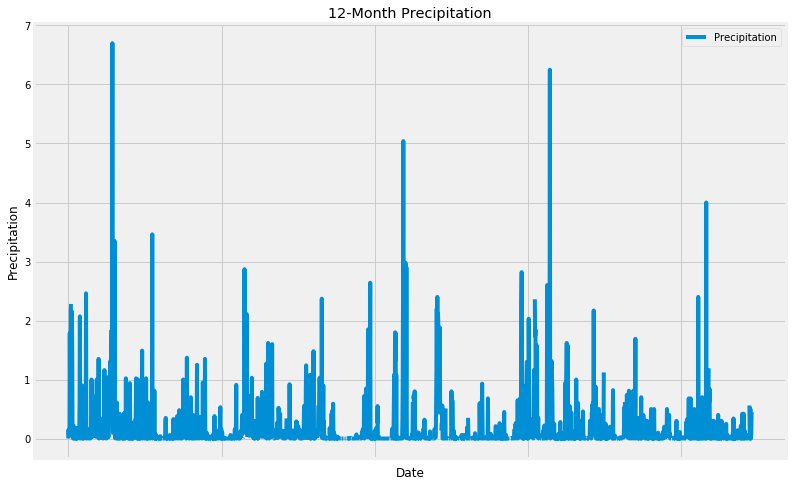

In [63]:
precip_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_year).\
                                order_by(Measurement.date).all()

precip_df = pd.DataFrame(precip_last_year, columns = ['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)

precip_df.plot(figsize=(12,8))
plt.title('12-Month Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.savefig('precip_data.png', bbox_inches='tight')

In [64]:
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [70]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(Measurement.station).group_by(Measurement.station).count()
print(station_number)

9


In [79]:
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()
most_active_df = pd.DataFrame(most_active, columns = ['Station', 'Station Count'])
most_active_df.set_index('Station')

,Station Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [82]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

USC00519281 = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station == 'USC00519281').all()
print(USC00519281)

[(54.0, 85.0, 71.66378066378067)]


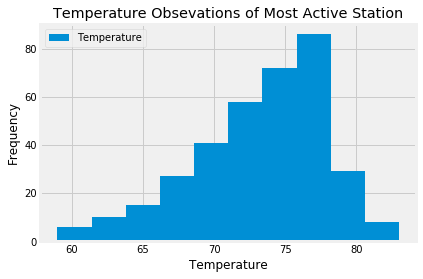

In [91]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_station = session.query(Measurement.tobs).filter(Measurement.date >= past_year).\
                             filter(Measurement.station == 'USC00519281').\
                             order_by(Measurement.tobs).all()

tobs_station_df = pd.DataFrame(tobs_station, columns = ['Temperature'])

tobs_station_df.plot(kind='hist')
plt.title('Temperature Obsevations of Most Active Station')
plt.xlabel('Temperature')
plt.savefig('weather_freq.png')

In [131]:
def calc_temps(trip_start, trip_end):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                         filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).all()

print(calc_temps(trip_start, trip_end))

[(70.0, 78.71111111111111, 85.0)]


In [111]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_start = trip_start - dt.timedelta(days=365)
prev_end = trip_end - dt.timedelta(days=365)

print(calc_temps(prev_start, prev_end))

[72.0, 78.08571428571429, 83.0]


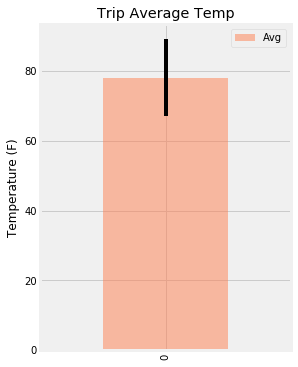

In [141]:
prev_trip = calc_temps(prev_start, prev_end)

prev_df = pd.DataFrame(prev_trip, columns = ['Min', 'Avg', 'Max'])

yerr = prev_df['Max'] - prev_df['Min']

prev_df.plot.bar(y='Avg', yerr=yerr, figsize=(4,6), color='coral', alpha=0.5)
plt.title('Trip Average Temp')
plt.ylabel('Temperature (F)')
plt.savefig('trip_avg_temp.png')

In [151]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
                         func.sum(Measurement.prcp)).filter(Measurement.date >= prev_start).\
                         filter(Measurement.station == Station.station).\
                         filter(Measurement.date <= prev_end).group_by(Measurement.station).\
                         order_by(func.sum(Measurement.prcp).desc()).all()
rain_df = pd.DataFrame(rainfall, columns = ['Station ID', 'Station Name', 'Latitude', 'Longitude', 'Elevation', 'Precipitation'])
rain_df

,Station ID,Station Name,Latitude,Longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,8.99
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.47
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.02
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.84
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.56
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.15
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


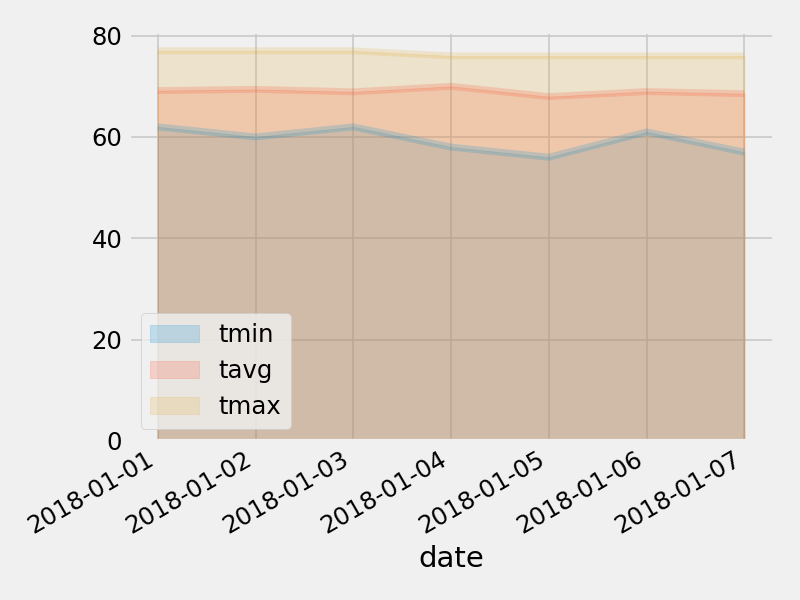

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
